In [1]:
%load_ext autoreload
%autoreload 2

## Loading stuff

In [2]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from lda import LDA
from bmm import BMM


In [3]:
np.random.seed(0)
# load data
data = sio.loadmat('kos_doc_data.mat')
A = np.array(data['A'])   # word counts for training (doc ID, word ID, count)
B = data['B']             # word counts for testing  (doc ID, word ID, count)
V = data['V']             # set of words = vocabulary

# defining indexes
DOCID_IND = 0
WORDID_IND = 1
COUNT_IND = 2

# CONVERTING MATLAB INDECES IN STANDARD PROGRAMMING INDICES
A[:,WORDID_IND] -= 1
B[:,WORDID_IND] -= 1

A.shape, B.shape, V.shape

((205211, 3), (147949, 3), (6906, 1))

## Question A

#### Using A, find the maximum likelihood multinomial over words, and show the 20 largest probability items in a histogram

In [92]:
total_word_count = np.sum(A[:,COUNT_IND])
betas = np.array([np.sum(A[A[:,WORDID_IND] == i][:,COUNT_IND])/total_word_count for i in range(len(V))])

print(betas[:4])


[1.47113991e-05 6.25234463e-05 4.78120472e-05 2.94227983e-05]


In [93]:
def get_sorted_params(params, vocab, N, top=True):
    if top:
        sorted_indices = np.argsort(params)[::-1]
        sorted_names = vocab[sorted_indices]
        ret_names = sorted_names[:N][::-1]
        ret_params = params[sorted_indices][:N][::-1]
    else:
        sorted_indices = np.argsort(params)
        sorted_names = vocab[sorted_indices]
        ret_names = sorted_names[:N]
        ret_params = params[sorted_indices][:N]

    ret_names = [name[0][0] for name in ret_names] # due to vocabulary struct
    return ret_params, ret_names


In [94]:
def plot_barh(probs, names, N, title=None):
    plt.style.use('seaborn')
    xx = np.linspace(0, N, N)
    plt.figure(figsize=(N, N))

    plt.barh(xx, probs)
    plt.yticks(xx, labels=names)
    plt.ylim([-0.7, N+0.7])

    plt.ylabel("Word", fontweight="bold", fontsize=15)
    plt.xlabel("Probability of word", fontweight="bold", fontsize=15)
    if title:
        plt.title(title, fontweight="bold", fontsize=18)


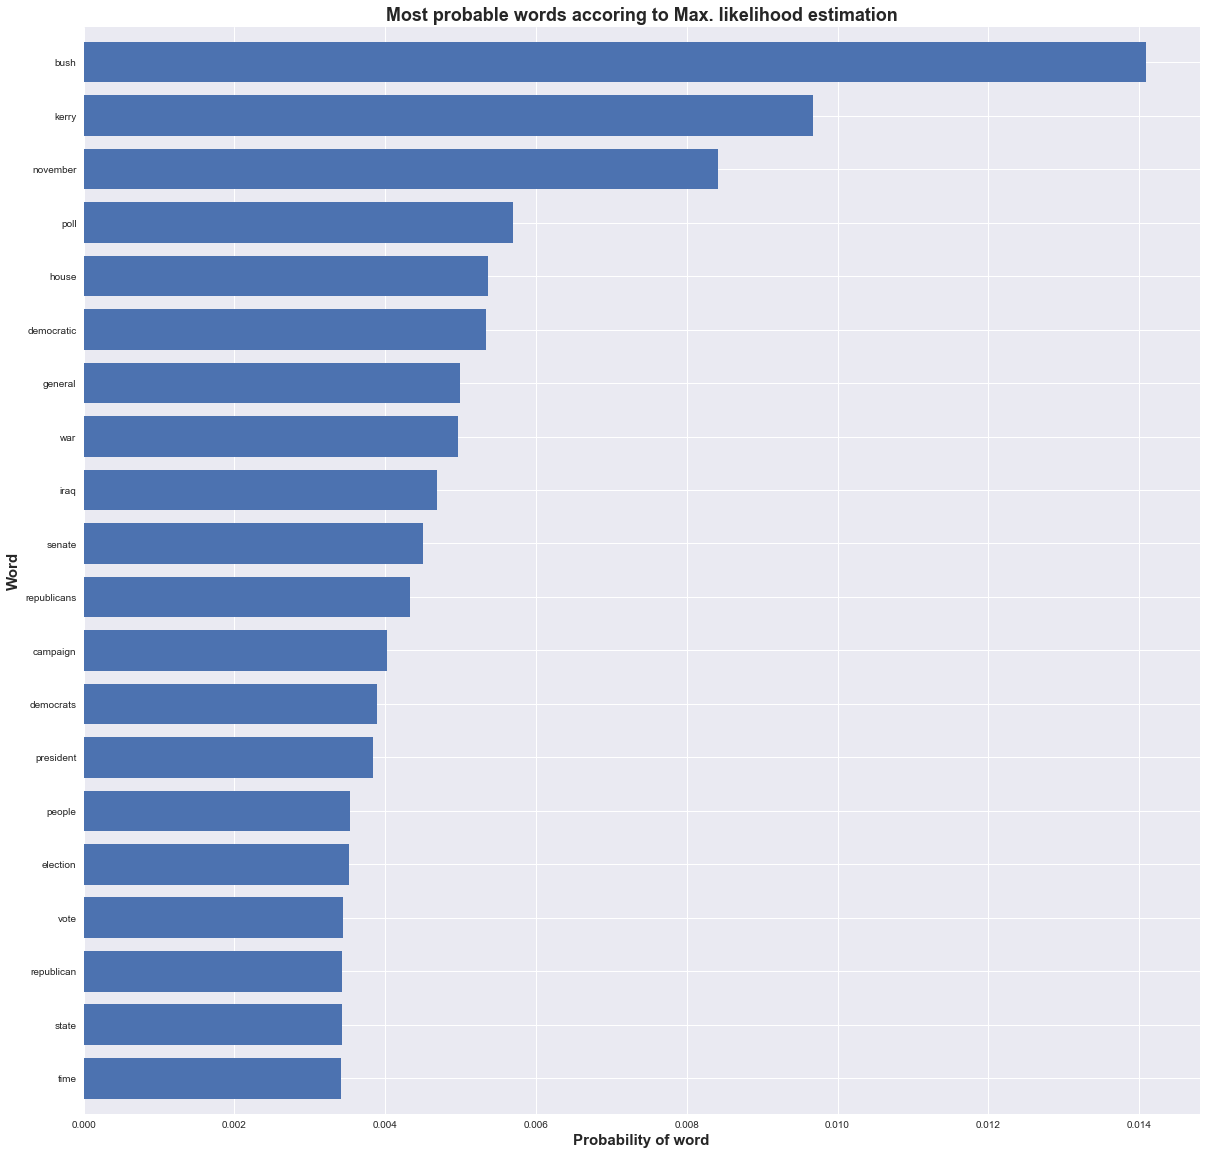

In [85]:
n = 20

printed_betas, printed_names = get_sorted_params(betas, V, N=n, top=True)

plot_barh(printed_betas, printed_names, N=n, title="Most probable words accoring to Max. likelihood estimation")

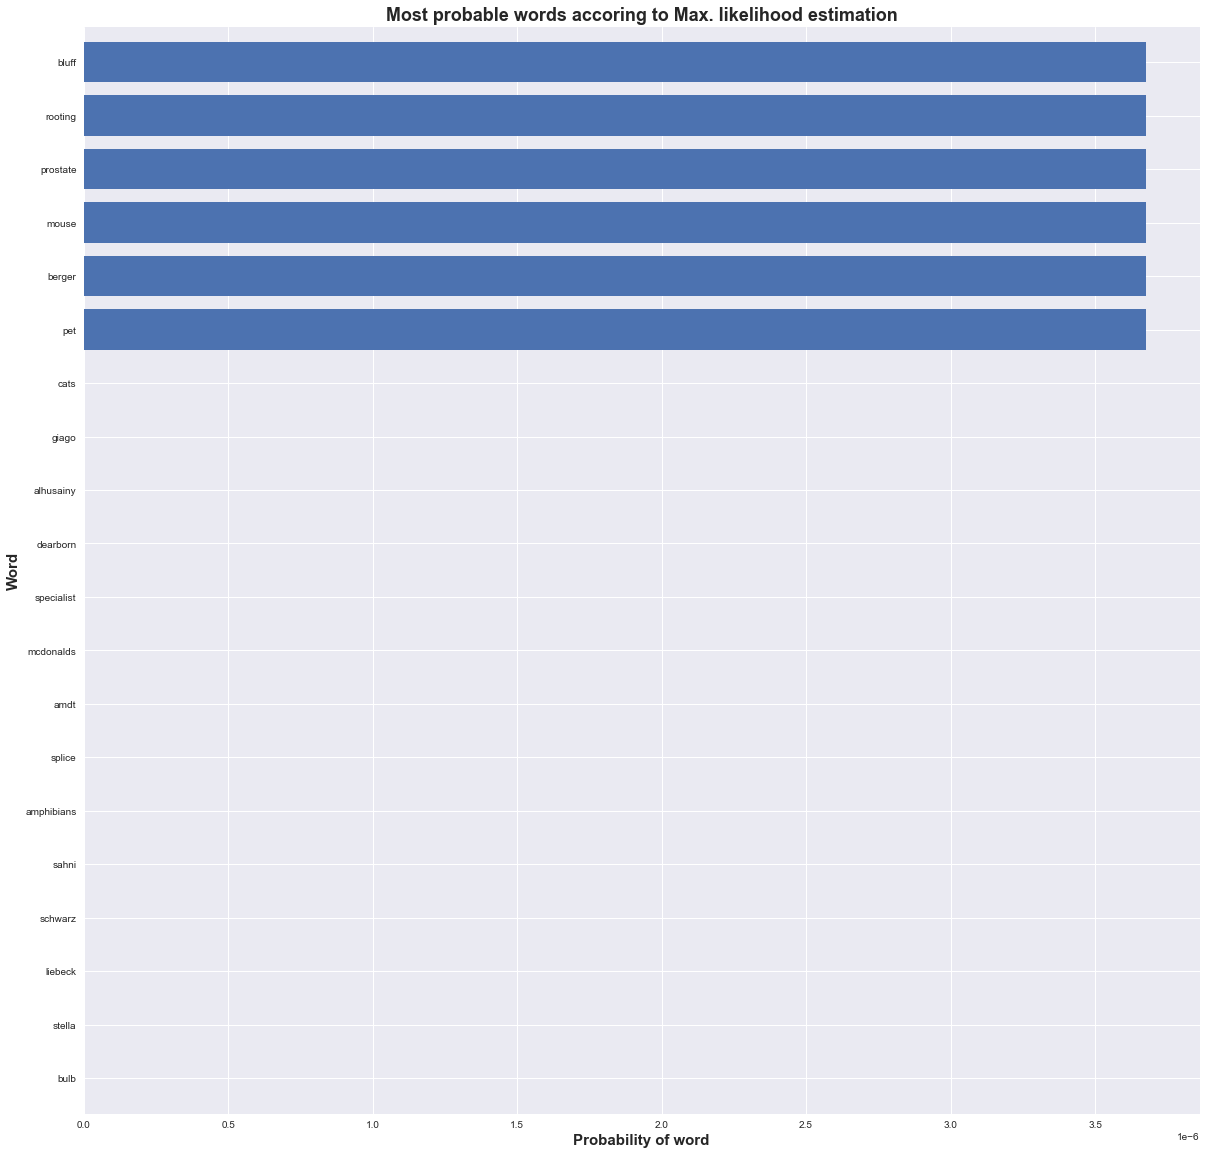

In [95]:
n = 20

printed_betas_low, printed_names_low = get_sorted_params(betas, V, N=n, top=False)

plot_barh(printed_betas_low, printed_names_low, N=n, title="Most probable words accoring to Max. likelihood estimation")

## Question B

#### Do Bayesian inference using symmetric Dirichlet prior with a concentration parameter alpha on the word probabilities

In [71]:
word_count = np.array([np.sum(A[A[:,WORDID_IND] == i][:,COUNT_IND]) for i in range(len(V))])

In [72]:
alpha = 0.1
dirich_params = word_count + alpha
dirich_betas = dirich_params/np.sum(dirich_params)

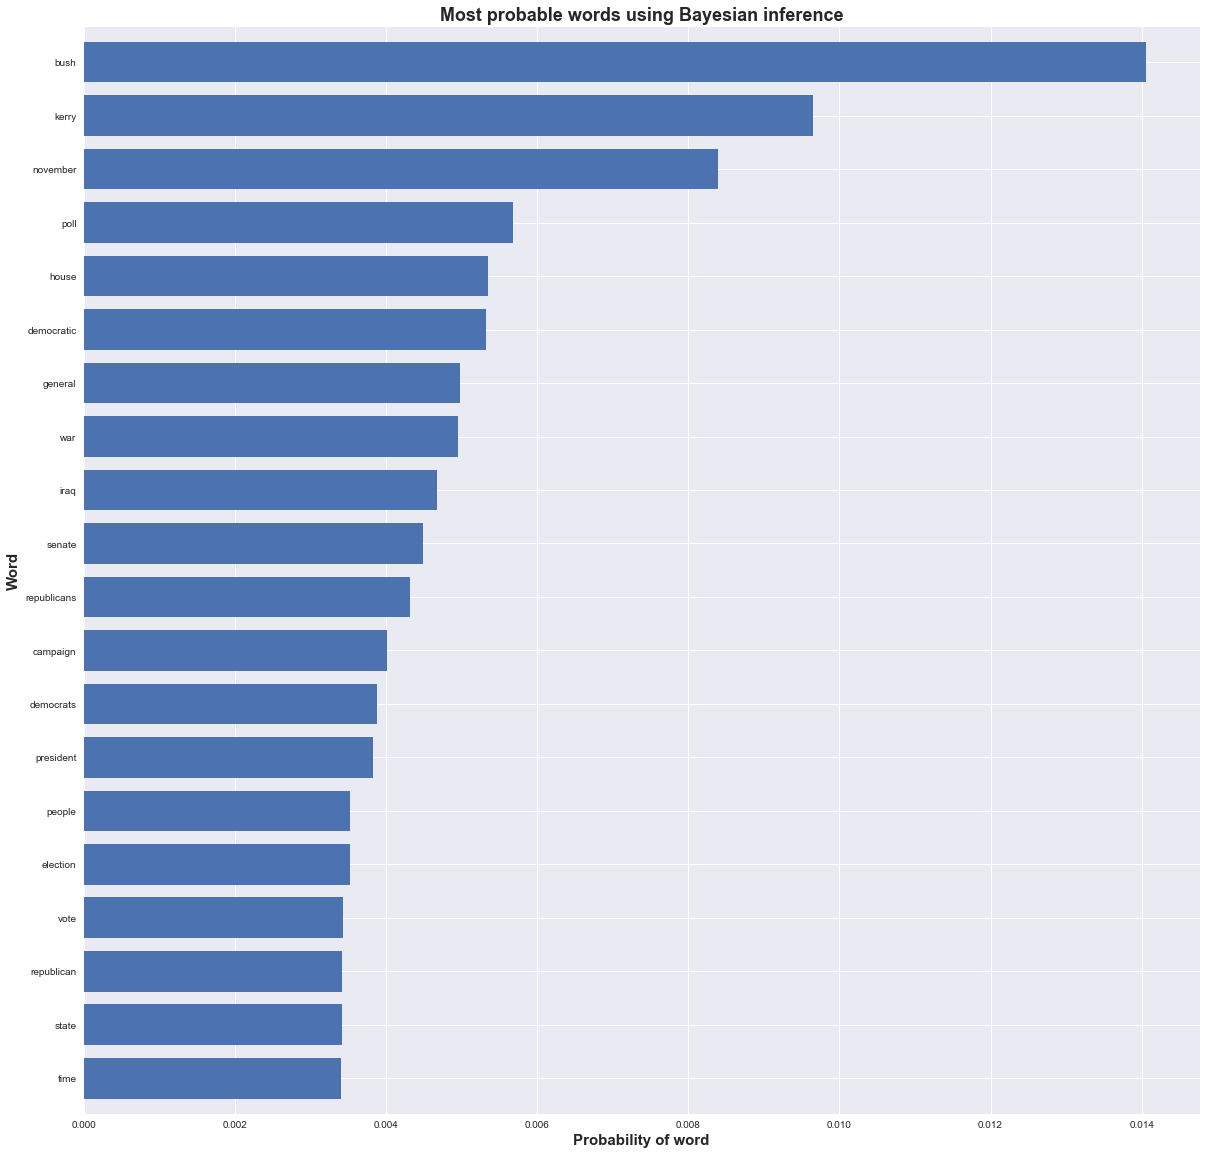

In [86]:
n = 20
top_dirich_betas, top_dirich_namewords = get_sorted_params(dirich_betas, vocab=V, N=n, top=True)

plot_barh(top_dirich_betas, top_dirich_namewords, N=n, title="Most probable words using Bayesian inference")

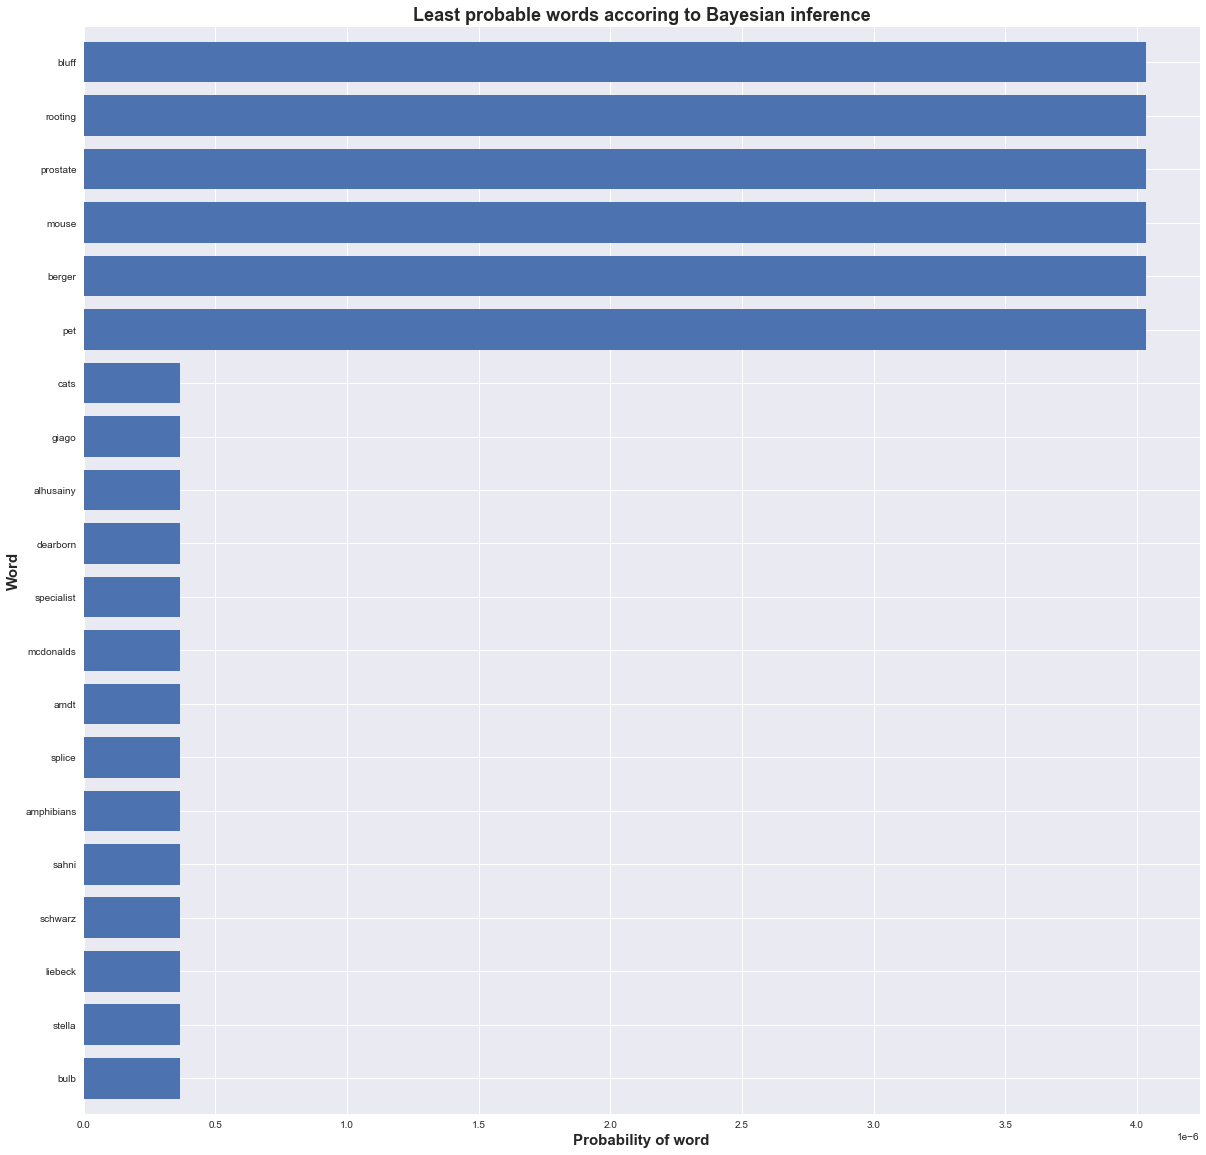

In [96]:
n = 20
low_dirich_betas, low_dirich_namewords = get_sorted_params(dirich_betas, vocab=V, N=n, top=False)

plot_barh(low_dirich_betas, low_dirich_namewords, N=n, title="Least probable words accoring to Bayesian inference")

In [113]:
def plot_double_barh(probs1, probs2, names, N, lbl1, lbl2, title=None):
    plt.style.use('seaborn')
    xx = np.linspace(0, N, N)
    h = 0.35
    plt.figure(figsize=(N, N))

    plt.barh(xx, probs1, h, label=lbl1)
    plt.barh(xx-h, probs2, h, label=lbl2)
    plt.yticks(xx - h/2, labels=names)
    plt.ylim([-1.5, N+0.7])
    plt.legend(loc=4, fontsize=20)

    plt.ylabel("Word", fontweight="bold", fontsize=15)
    plt.xlabel("Probability of word", fontweight="bold", fontsize=15)
    if title:
        plt.title(title, fontweight="bold", fontsize=18)

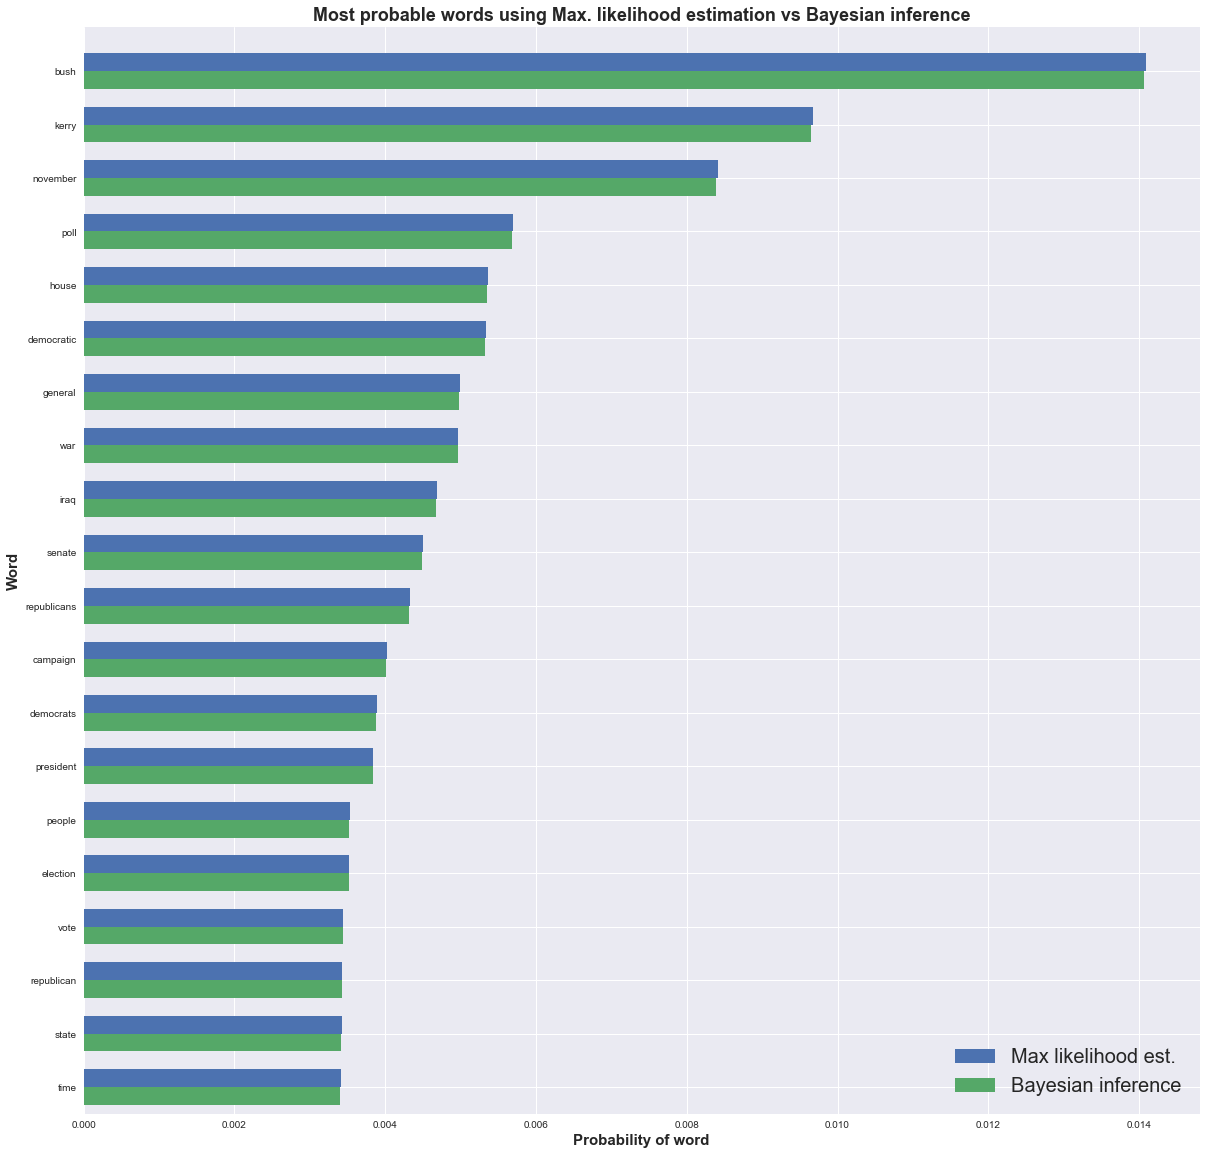

In [104]:
n = 20
plot_double_barh(printed_betas, top_dirich_betas, printed_names, N=n,
                 lbl1="Max likelihood est.", lbl2="Bayesian inference",
                 title="Most probable words using Max. likelihood estimation vs Bayesian inference")

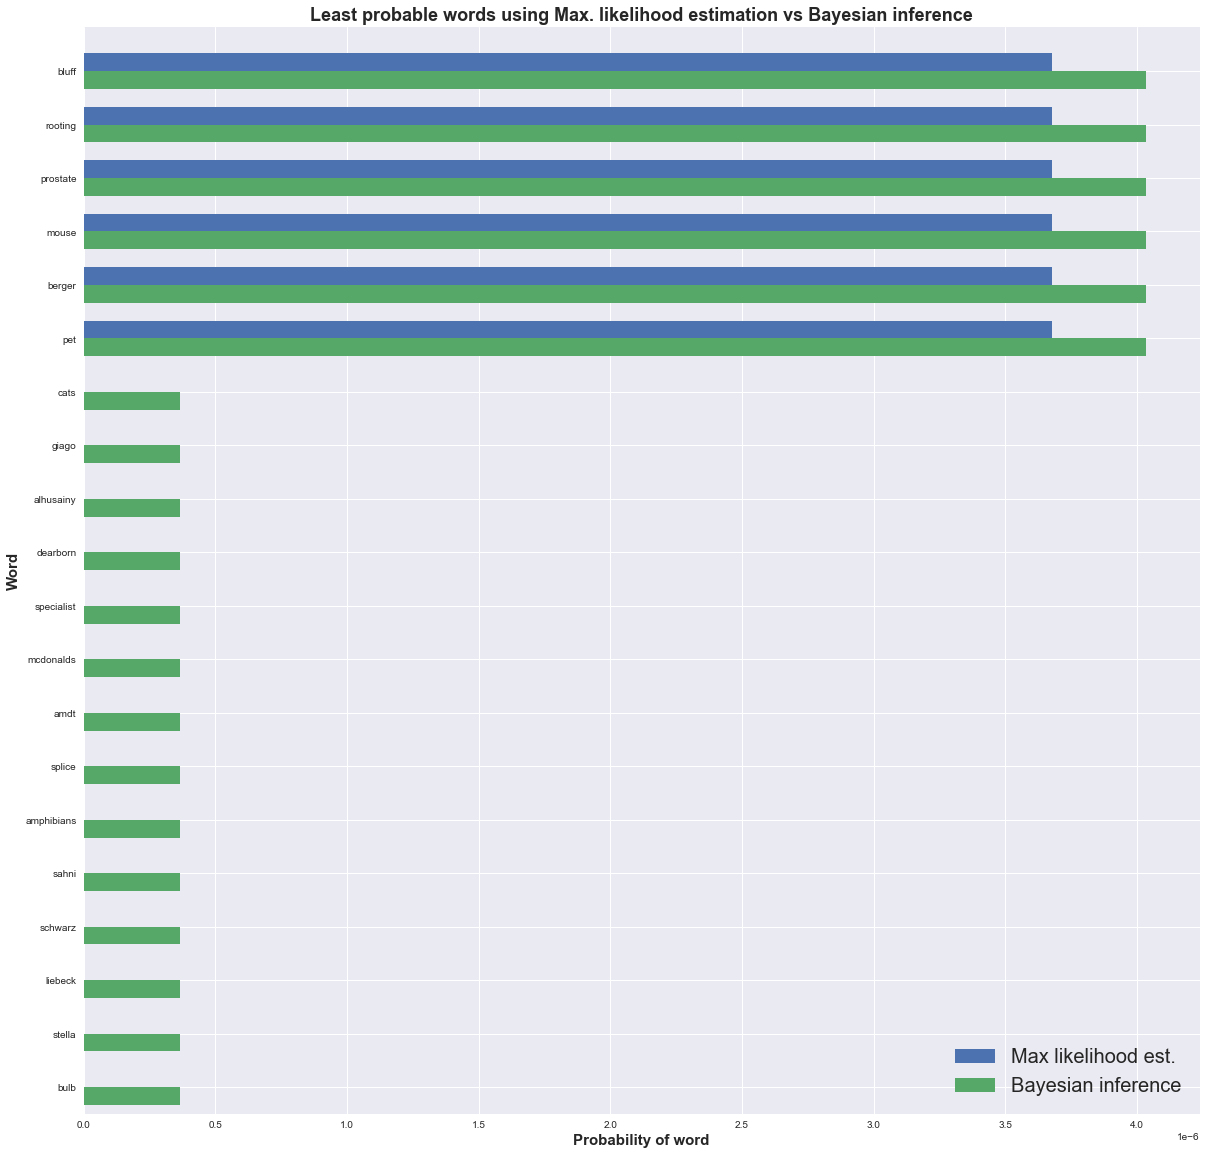

In [105]:
n = 20
plot_double_barh(printed_betas_low, low_dirich_betas, low_dirich_namewords, N=n,
                 lbl1="Max likelihood est.", lbl2="Bayesian inference",
                 title="Least probable words using Max. likelihood estimation vs Bayesian inference")

In [106]:
alpha_large = 100
dirich_params_large = word_count + alpha_large
dirich_betas_large = dirich_params_large/np.sum(dirich_params_large)

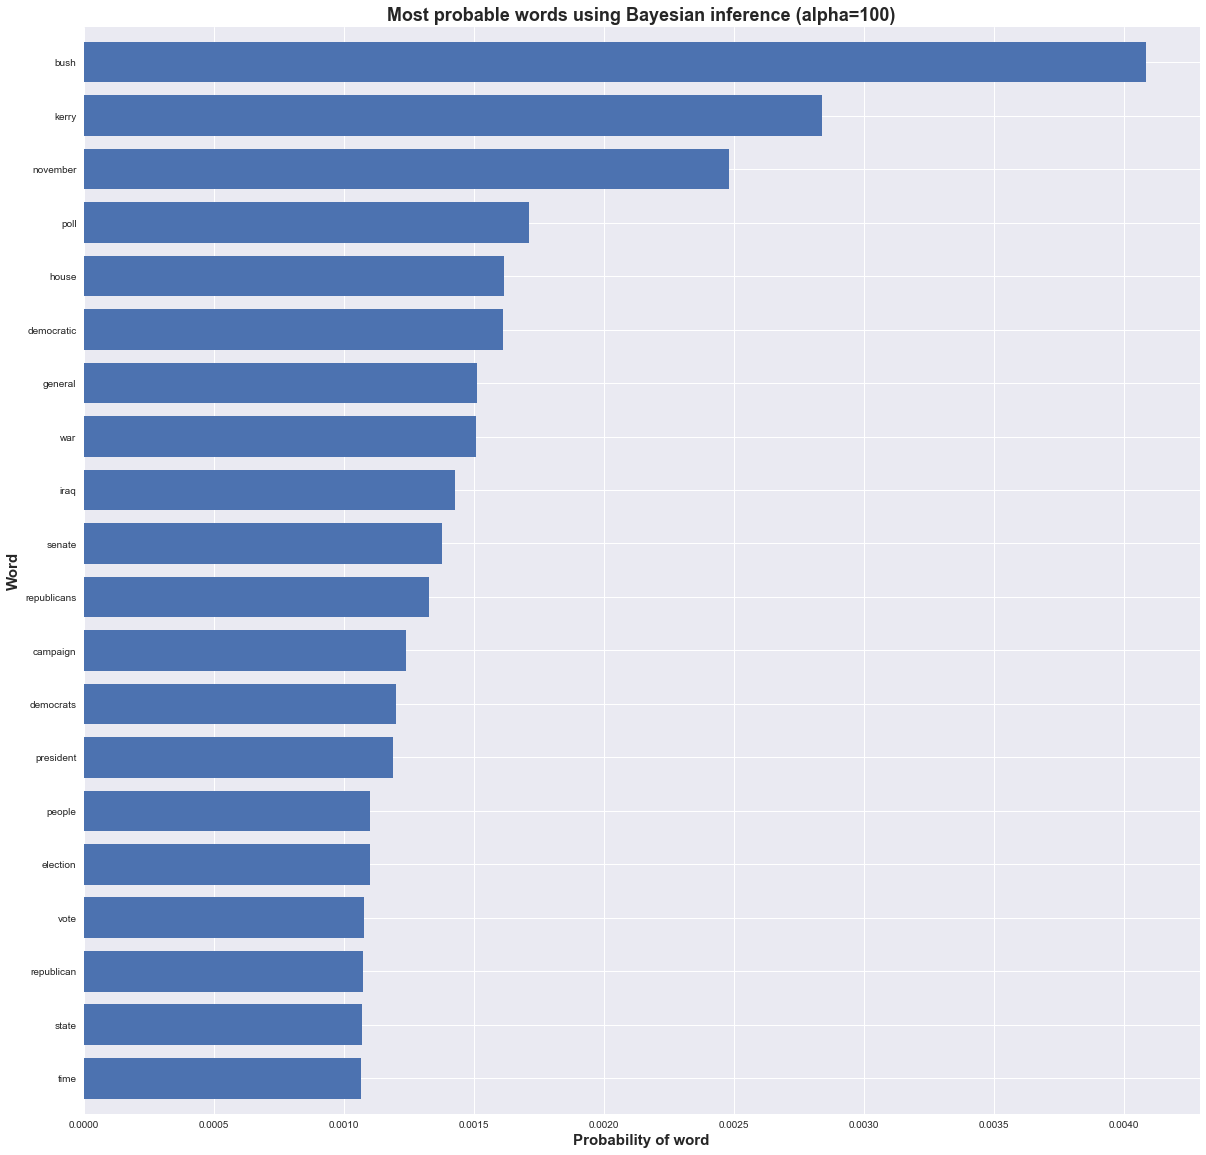

In [107]:
n = 20
top_dirich_betas_large, top_dirich_namewords_large = get_sorted_params(dirich_betas_large, vocab=V, N=n, top=True)

plot_barh(top_dirich_betas_large, top_dirich_namewords_large, N=n, title="Most probable words using Bayesian inference (alpha=100)")

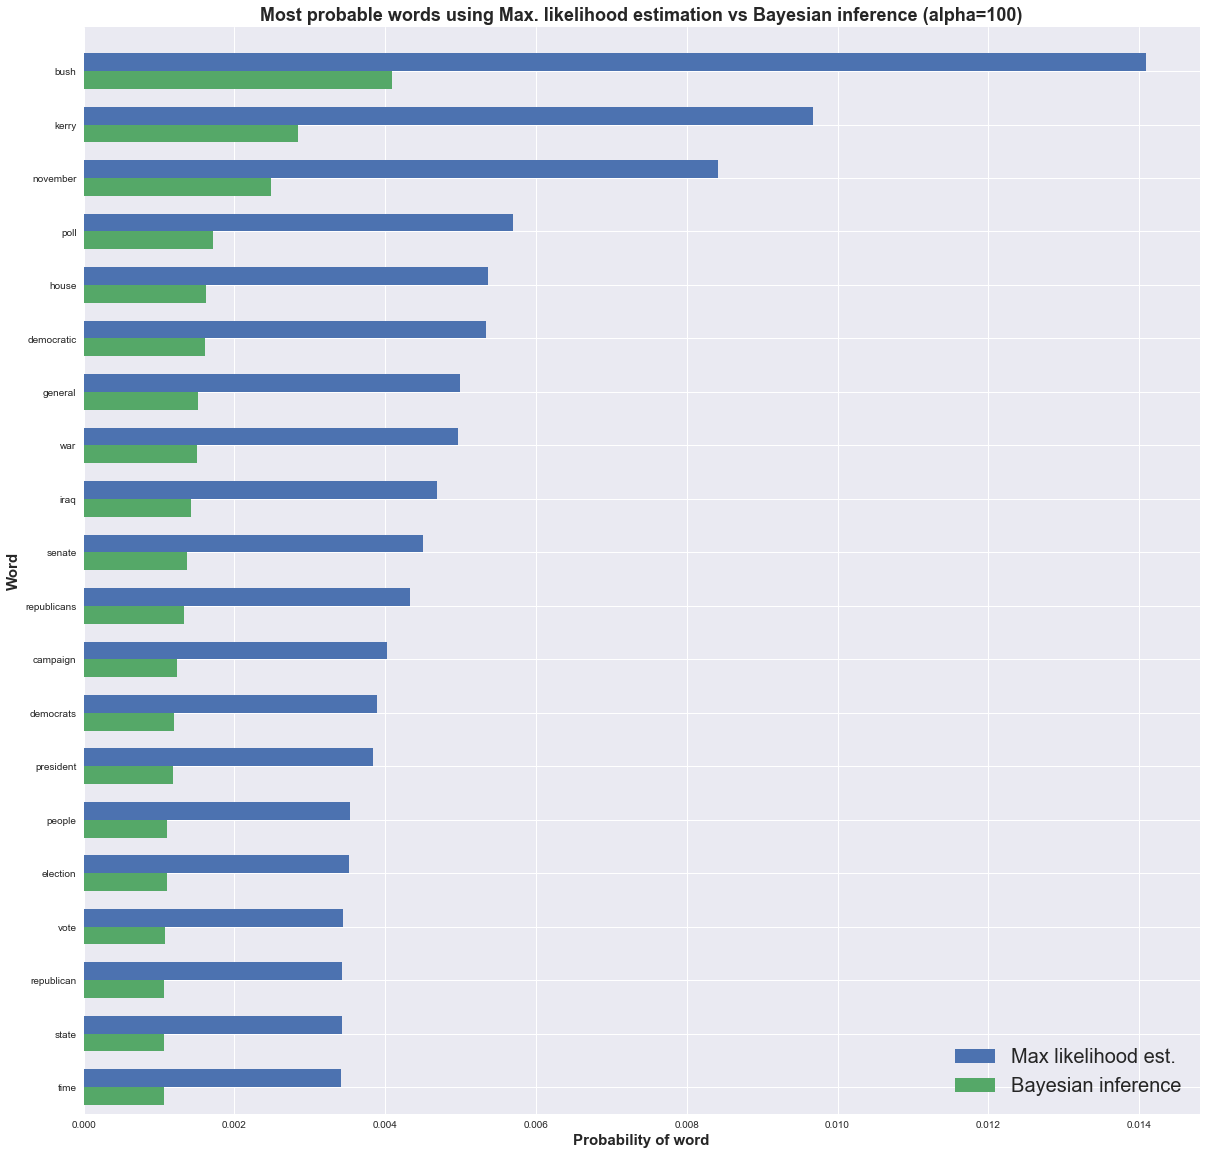

In [108]:
n = 20
plot_double_barh(printed_betas, top_dirich_betas_large, top_dirich_namewords_large, N=n,
                 lbl1="Max likelihood est.", lbl2="Bayesian inference",
                 title="Most probable words using Max. likelihood estimation vs Bayesian inference (alpha=100)")

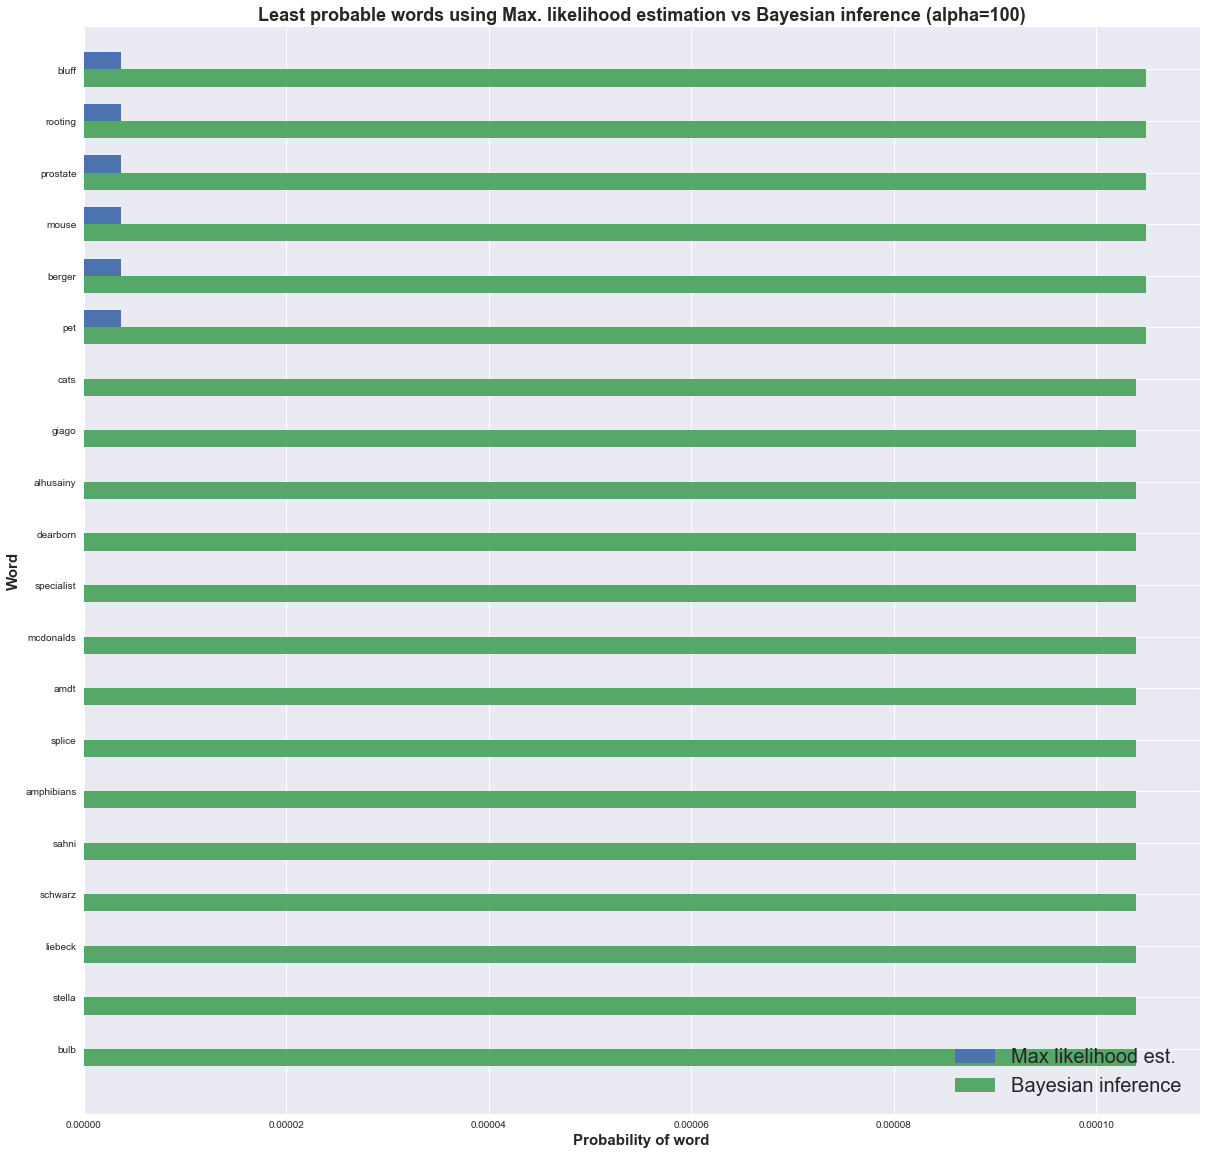

In [114]:
n = 20
low_dirich_betas_large, low_dirich_namewords_large = get_sorted_params(dirich_betas_large, vocab=V, N=n, top=False)

plot_double_barh(printed_betas_low, low_dirich_betas_large, low_dirich_namewords_large, N=n,
                 lbl1="Max likelihood est.", lbl2="Bayesian inference",
                 title="Least probable words using Max. likelihood estimation vs Bayesian inference (alpha=100)")

## Question C

#### Log probability of text 2001

In [8]:
word_count = np.array([np.sum(A[A[:,WORDID_IND] == i][:,COUNT_IND]) for i in range(len(V))])

alpha = 0.1
dirich_params = word_count + alpha
dirich_betas = dirich_params/np.sum(dirich_params)

In [9]:
doc_id = 2001

log_prob = 0
for entry in B:
    if entry[DOCID_IND] == doc_id:
        log_prob += entry[COUNT_IND]*np.log(dirich_betas[entry[WORDID_IND]])

log_prob


-3691.2167892062653

#### Perplexity of text 2001

In [10]:
N_words_doc = np.sum(B[B[:,DOCID_IND] == doc_id][:,COUNT_IND])

ppxt_doc = np.exp(-log_prob/N_words_doc)
ppxt_doc

4398.984801609514

In [11]:
def calculate_logProb(doc_id, test_set):
    log_prob = 0
    for entry in test_set:
        if entry[DOCID_IND] == doc_id:
            log_prob += entry[COUNT_IND]*np.log(dirich_betas[entry[WORDID_IND]])
    return log_prob


def calculate_perplexity(doc_id, test_set):
    log_prob = calculate_logProb(doc_id, test_set)
    N_words_doc = np.sum(test_set[test_set[:,DOCID_IND] == doc_id][:,COUNT_IND])
    ppxt = np.exp(-log_prob/N_words_doc)
    return ppxt

#### Perplexity of all documents

In [12]:
unique_test_ids = np.unique(B[:,DOCID_IND])
len(unique_test_ids)

1430

In [13]:
perplexities = []

for id in unique_test_ids:
    ppxt = calculate_perplexity(id, B)
    perplexities.append(ppxt)

Text(0.5, 1.0, 'Document perplexity using Bayesian Inference vs Uniform Multinomial')

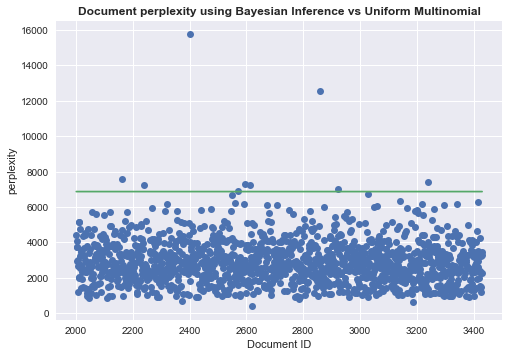

In [149]:
plt.plot(unique_test_ids, perplexities, 'o', label="Bayesian inference")

unique_words = np.unique(B[:,WORDID_IND])
unif_mult = [len(unique_words)]*len(unique_test_ids)

plt.plot(unique_test_ids, unif_mult, label="Uniform multinomial")

plt.xlabel("Document ID")
plt.ylabel("perplexity")
plt.title("Document perplexity using Bayesian Inference vs Uniform Multinomial", fontweight="bold")

In [16]:
test_docs_ids = np.unique(B[:,0])

log_prob_testset = 0
log_prob_docs = []
word_count_docs = []

for d in test_docs_ids:
    # get documents with id=d
    test_documents = np.where(B[:, 0] == d)
    # words ids in doc d
    w = B[test_documents, 1][0]
    # occurrencies of words in doc d
    c = B[test_documents, 2][0]
    
    # Calculate log prob for doc d
    log_prob_aux = 0
    for i, m in enumerate(w):
        # iterate over all word ids in doc d.
        log_prob_aux += c[i] * np.log(dirich_betas[m]) 
    
    log_prob_testset += log_prob_aux
    
    log_prob_docs.append(log_prob_aux)
    word_count_docs.append(sum(c))

N_testset = np.sum(B[:,2])
ppxt_testset = np.exp(- 1/N_testset * log_prob_testset)
print('Perplexity test set =', ppxt_testset)

Perplexity test set = 2697.1068182222075


## Question D

In [3]:
# load data again (bmm and lda functions uses MATLAB indexing)
data = sio.loadmat('kos_doc_data.mat')
A = np.array(data['A'])
B = data['B']
V = data['V']

#### Using Bayesian Mixture Models and Gibbs sampling to get distribution of docs over topics 

In [4]:
np.random.seed(1)

K = 20  # number of clusters
alpha = 10  # parameter of the Dirichlet over mixture components
gamma = 0.1  # parameter of the Dirichlet over words
n_iters = 50
perplexity, swk, list_sk_docs = BMM(A, B, K, alpha, gamma, num_iters_gibbs=n_iters)
print(perplexity)

2092.268119165107


In [21]:
# summing over columns to get c_k
print(list_sk_docs.shape)
cluster_doc_count = np.sum(list_sk_docs, axis=0)
# calculating c_k + alpha
cluster_doc_count_alpha = cluster_doc_count + alpha
# theta_k = predicitive mean Dir(c_k+alpha) = (c_k + alpha)/sum_{k}(c_k + alpha)
thetas = cluster_doc_count_alpha/sum(cluster_doc_count_alpha)
thetas.shape

(50, 20)


(20,)

In [26]:
def get_thetas_at_iter(list_sk_docs, alpha, gibbs_iter):
    cluster_doc_count = list_sk_docs[gibbs_iter,:]
    cluster_doc_count_alpha = cluster_doc_count + alpha
    thetas_iter = cluster_doc_count_alpha/np.sum(cluster_doc_count_alpha)
    return thetas_iter


def get_thetas_per_iter(list_sk_docs, alpha, total_iters):
    thetas_per_iter = []
    for iter in range(total_iters):
        thetas_iter = get_thetas_at_iter(list_sk_docs, alpha, iter)
        thetas_per_iter.append(thetas_iter)
    
    return np.array(thetas_per_iter)


def plot_thetas(list_sk_docs, alpha, total_iters):
    thetas_per_iter = get_thetas_per_iter(list_sk_docs, alpha, total_iters)
    thetas_per_iter = np.transpose(thetas_per_iter)

    plt.figure(figsize=(0.7*thetas_per_iter.shape[0], 0.5*thetas_per_iter.shape[0]))
    
    x = range(total_iters)
    for k in range(thetas_per_iter.shape[0]):
        plt.plot(x, thetas_per_iter[k], label='theta_'+str(k))
    
    plt.xlabel("Gibbs iteration", fontweight="bold", fontsize=13)
    plt.ylabel("Posterior probability of mixture component (topic)", fontweight="bold", fontsize=13)
    plt.title("Evolution of thetas", fontweight="bold", fontsize=16)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


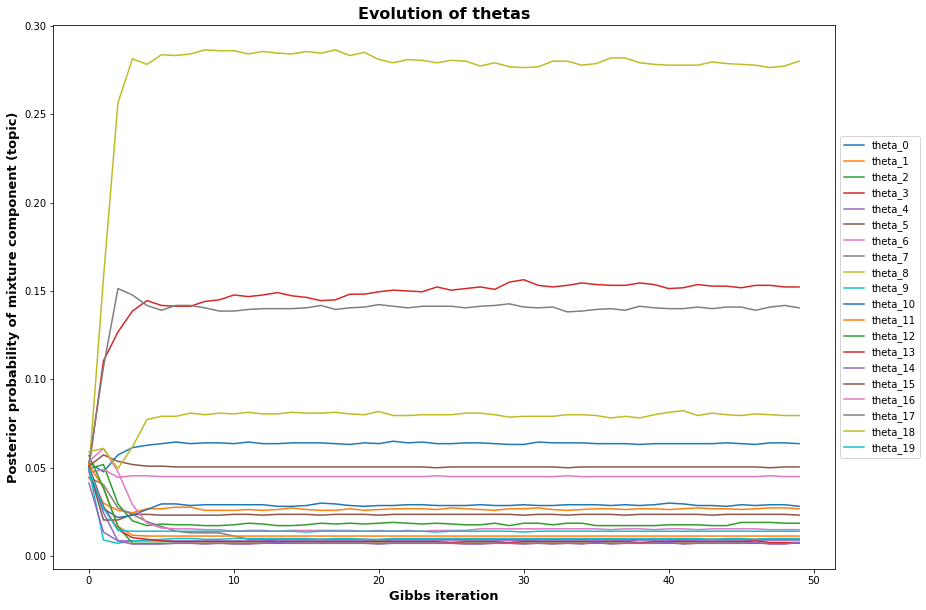

In [27]:
plot_thetas(list_sk_docs, alpha, n_iters)

In [28]:
np.random.seed(3)

K = 20  # number of clusters
alpha = 10  # parameter of the Dirichlet over mixture components
gamma = 0.1  # parameter of the Dirichlet over words
n_iters = 50
perplexity, swk, list_sk_docs = BMM(A, B, K, alpha, gamma, num_iters_gibbs=n_iters)
print(perplexity)

2123.59626206069


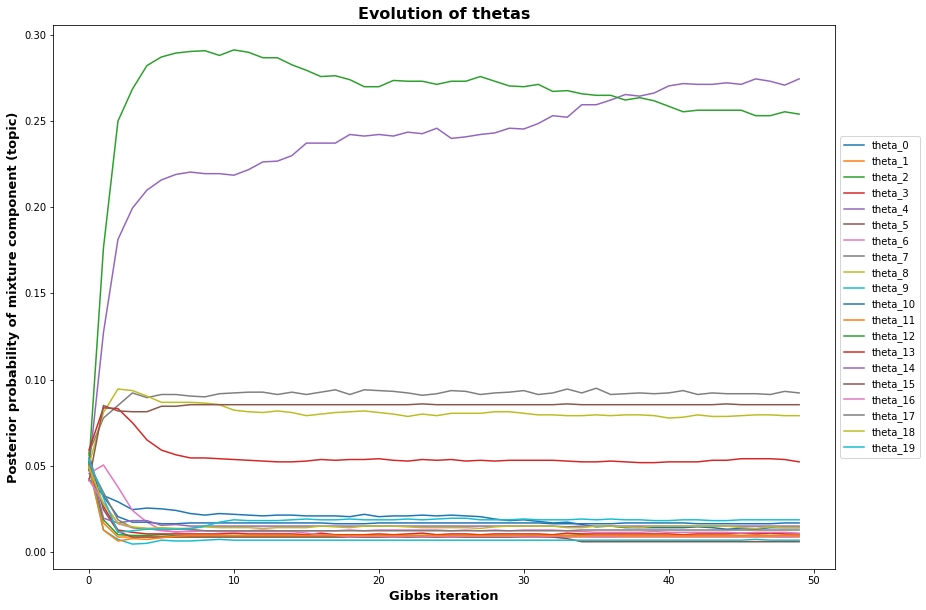

In [29]:
plot_thetas(list_sk_docs, alpha, n_iters)

## Question E

In [ ]:
# load data again (bmm and lda functions uses MATLAB indexing)
data = sio.loadmat('kos_doc_data.mat')
A = np.array(data['A'])
B = data['B']
V = data['V']

## Testing